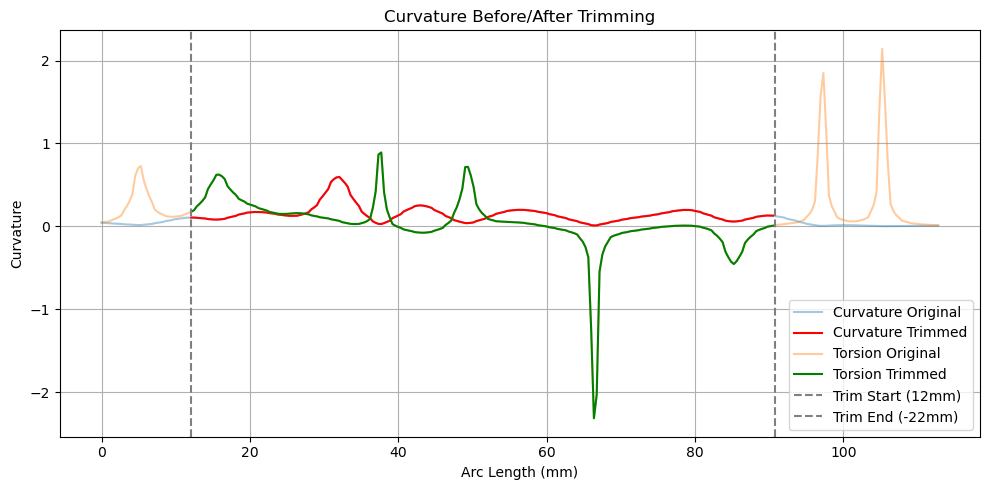

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

def trim_by_length(coords, curvature, torsion, trim_start=12.0, trim_end=22.0):
    diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    arc_length = np.concatenate([[0], np.cumsum(diffs)])
    total_length = arc_length[-1]

    start_idx = np.searchsorted(arc_length, trim_start, side='right')
    end_idx = np.searchsorted(arc_length, total_length - trim_end, side='right')

    coords_trim = coords[start_idx:end_idx]
    curvature_trim = curvature[start_idx:end_idx]
    torsion_trim = torsion[start_idx:end_idx]

    diffs_trim = np.linalg.norm(np.diff(coords_trim, axis=0), axis=1)
    abscissas_trim = np.concatenate([[0], np.cumsum(diffs_trim)])

    return coords_trim, curvature_trim, torsion_trim, abscissas_trim, start_idx, end_idx

def read_ply_with_curvature_torsion(filepath):
    coords = []
    curvature = []
    torsion = []
    vertex_count = 0

    with open(filepath, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if line.startswith("element vertex "):  # 注意后面有空格，避免匹配 vertex_seq
            vertex_count = int(line.strip().split()[-1])
        if line.strip() == "end_header":
            start_index = i + 1
            break

    for line in lines[start_index:start_index + vertex_count]:
        parts = line.strip().split()
        if len(parts) < 8:
            continue
        coords.append([float(parts[0]), float(parts[1]), float(parts[2])])
        curvature.append(float(parts[6]))
        torsion.append(float(parts[7]))

    coords = np.array(coords)
    curvature = np.array(curvature)
    torsion = np.array(torsion)

    diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    arc_length = np.concatenate([[0], np.cumsum(diffs)])

    coords_trim, curvature_trim, torsion_trim, abscissas_trim, start_idx, end_idx = trim_by_length(
        coords, curvature, torsion)

    return {
        'coords': coords,
        'curvature': curvature,
        'torsion': torsion,
        'arc_length': arc_length,
        'coords_trim': coords_trim,
        'curvature_trim': curvature_trim,
        'torsion_trim': torsion_trim,
        'abscissas_trim': abscissas_trim,
        'start_idx': start_idx,
        'end_idx': end_idx
    }

# 示例：读取并绘图
ply_path = r"D:\!BraVa_src\ica_results\brava(v-modelr)\BG0001_L.ply"

data = read_ply_with_curvature_torsion(ply_path)

arc = data['arc_length']
curv = data['curvature']
tors = data['torsion']
arc_trim = arc[data['start_idx']:data['end_idx']]
curv_trim = data['curvature_trim']
tors_trim = data['torsion_trim']

plt.figure(figsize=(10, 5))
plt.plot(arc, curv, label='Curvature Original', alpha=0.4)
plt.plot(arc_trim, curv_trim, label='Curvature Trimmed', color='red')
plt.plot(arc, tors, label='Torsion Original', alpha=0.4)
plt.plot(arc_trim, tors_trim, label='Torsion Trimmed', color='green')

plt.axvline(12.0, color='gray', linestyle='--', label='Trim Start (12mm)')
plt.axvline(arc[-1] - 22.0, color='gray', linestyle='--', label='Trim End (-22mm)')

plt.xlabel("Arc Length (mm)")
plt.ylabel("Curvature")
plt.title("Curvature Before/After Trimming")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
